<a href="https://colab.research.google.com/github/wittenator/pimai/blob/master/src/notebook/src/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  from google.colab import files
  !pip install torch torchvision skorch
  !pip install hypertools
  colab = True
except:
  pass

     |████████████████████████████████| 112kB 4.8MB/s 
     |████████████████████████████████| 6.7MB 6.5MB/s 
  Created wheel for hypertools: filename=hypertools-0.6.2-cp36-none-any.whl size=46622 sha256=adeec00fc9d140adfdaa5335737660f511c6b216ccadde135318b498f686bb79
  Stored in directory: /root/.cache/pip/wheels/53/31/3a/0a3f26ae77857ae19ee5947fd2ee9bf34249fcd9c6c90636c2
Successfully built hypertools
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from datetime import datetime

from multiprocessing import cpu_count

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset, DataLoader

from torch.distributions import *

import skorch
import numpy as np
import hypertools as hyp

%load_ext tensorboard
%matplotlib inline
torch.autograd.set_detect_anomaly(True)

/usr/local/lib/python3.6/dist-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


## Dataset

In [0]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if use_cuda else {}
if not colab:
  train_loader = DataLoader(Subset(
      datasets.MNIST('/data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), indices=range(10000)),
      batch_size=64, shuffle=True, **kwargs)
  test_loader = DataLoader(Subset(
      datasets.MNIST('/data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), indices=range(10000)),
      batch_size=1000, shuffle=True, **kwargs)
else:
  train_loader = DataLoader(
      datasets.MNIST('/data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
      batch_size=64, shuffle=True, **kwargs)
  test_loader = DataLoader(
      datasets.MNIST('/data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
      batch_size=1000, shuffle=True, **kwargs)


## Generic autoencoder class

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        now = datetime.now()
        current_time = now.strftime("%Y%m%d-%H%M%S")
        self.writer = SummaryWriter(log_dir="/data/runs/"+current_time)
        self.embeddings = []
        self.embedding_labels =[]
    
    def trains(self, device, train_loader, optimizer, epoch):
        self.train()
        loss_sum = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = self.compute_loss_train(data, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            self.writer.add_scalar('Loss/train', loss.item(), epoch*len(train_loader)+batch_idx)
            
    def tests(self, device, test_loader):
        self.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                loss, output = self.compute_loss_test(data, target)
                test_loss += loss
                l1 = F.l1_loss(output, data.view(-1, 784), reduction='sum')

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Reconstruction error: {}\n'.format(
            test_loss, l1))
        
    def add_embedding(self, loader):
        with torch.no_grad():
            labels = []
            embs = []
            for data, label in loader:
                data, label = data.to(device), label.to(device)
                labels.append(label)
                recon_batch, a, b = self(data)
                emb = self.reparameterize(a,b)
                embs.append(emb)
            print(type(tuple(embs)))
            self.embeddings.append(torch.cat(tuple(embs), dim=0).cpu().numpy())
            self.embedding_labels = torch.cat(tuple(labels), dim=0).cpu().numpy()
            
    def visualize_embeddings(self, epoch):
        hyp.plot(self.embeddings[epoch], '.', hue=self.embedding_labels, reduce='TSNE', ndims=2, save_path=f'/data/visualizations/{self.__class__.__name__}-{datetime.now().strftime("%Y%m%d-%H%M%S")}.svg' if not colab else None)

## Autoencoder

In [0]:
class SimpleAutoencoder(Autoencoder):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output       
    
    def compute_loss_train(self, data, target):
        output = self(data)
        return F.nll_loss(output, target)
    
    def compute_loss_test(self, data, target):
        output = self(data)
        return F.nll_loss(output, target, reduction='sum').item(), output  # sum up batch loss

In [0]:
model = SimpleAutoencoder().to(device)
optimizer = optim.Adadelta(model.parameters())

# plot model
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
#writer.add_image('mnist_images', img_grid)

scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 14 + 1):
    model.trains(device, train_loader, optimizer, epoch)
    model.tests(device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.325908


KeyboardInterrupt: 

## Gaussian Variational Autoencoder

In [0]:
class VAE(Autoencoder):
    def __init__(self, k=20):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, k)
        self.fc22 = nn.Linear(400, k)
        self.fc3 = nn.Linear(k, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #x = self.conv1(x)
        #x = F.relu(x)
        #x = self.conv2(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD
    
    def compute_loss_train(self, data, target):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar)
    
    def compute_loss_test(self, data, target):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar).item(), recon_batch  # sum up batch loss

In [0]:
vae = VAE(k=5).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 20 + 1):
    vae.trains(device, train_loader, optimizer, epoch)
    vae.tests(device, test_loader)
    vae.add_embedding(test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 35092.406250
Train Epoch: 1 [640/60000 (1%)]	Loss: -140224.656250
Train Epoch: 1 [1280/60000 (2%)]	Loss: -433097.312500
Train Epoch: 1 [1920/60000 (3%)]	Loss: -344460.562500
Train Epoch: 1 [2560/60000 (4%)]	Loss: -490082.156250
Train Epoch: 1 [3200/60000 (5%)]	Loss: -401398.562500
Train Epoch: 1 [3840/60000 (6%)]	Loss: -509622.843750
Train Epoch: 1 [4480/60000 (7%)]	Loss: -509667.843750
Train Epoch: 1 [5120/60000 (9%)]	Loss: -525838.187500
Train Epoch: 1 [5760/60000 (10%)]	Loss: -526258.937500
Train Epoch: 1 [6400/60000 (11%)]	Loss: -590626.125000
Train Epoch: 1 [7040/60000 (12%)]	Loss: -610762.812500
Train Epoch: 1 [7680/60000 (13%)]	Loss: -643493.562500
Train Epoch: 1 [8320/60000 (14%)]	Loss: -745541.125000
Train Epoch: 1 [8960/60000 (15%)]	Loss: -736790.187500
Train Epoch: 1 [9600/60000 (16%)]	Loss: -730691.250000
Train Epoch: 1 [10240/60000 (17%)]	Loss: -778353.125000
Train Epoch: 1 [10880/60000 (18%)]	Loss: -827219.937500
Train Epoch: 1 [11520/6

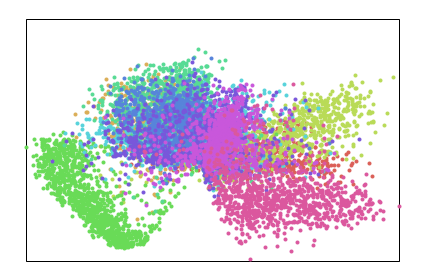

In [82]:
vae.visualize_embeddings(-1)

## Stick-breaking process

In [0]:
def stickbreakingprocess(k, a, b):
    a = a.to(device)
    b = b.to(device)
    eps = 20
    batch_size = a.size()[0]
    uniform_samples = Uniform(torch.tensor([eps*torch.finfo(torch.float).eps]), torch.tensor([1.0-eps*torch.finfo(torch.float).eps])).rsample(torch.tensor([batch_size,k])).squeeze().to(device)
    exp_a = torch.reciprocal(a + eps*torch.finfo(torch.float).eps)
    exp_b = torch.reciprocal(b + eps*torch.finfo(torch.float).eps)
    km = (1- uniform_samples.pow(exp_b)).pow(exp_a)
    
    #no Nans are allowed in the matrix
    #assert not torch.isnan(km).any().item()
    
    cumprods = torch.cat((torch.ones([batch_size, 1]).to(device), torch.cumprod(1-km, axis=1)), dim=1)
    sticks = cumprods[:,:-1]*km
    sticks[:, -1] = cumprods[:, -1] 
    return sticks

In [76]:
stickbreakingprocess(20, torch.rand(10,20), torch.rand(10,20)).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

## Stick-breaking Autoencoder

In [0]:
class SBVAE(Autoencoder):
    def __init__(self, k):
        super(SBVAE, self).__init__()
        self.k = k
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(784, 400)
        self.bn1 = nn.BatchNorm1d(num_features=self.k)
        self.bn2 = nn.BatchNorm1d(num_features=self.k)
        self.fc21 = nn.Linear(400, self.k)
        self.fc22 = nn.Linear(400, self.k)
        
        
        self.fc3 = nn.Linear(self.k, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #x = self.conv1(x)
        #x = F.relu(x)
        #x = self.conv2(x)
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return F.softplus(self.fc21(h1)), F.softplus(self.fc22(h1))

    def reparameterize(self, a, b):
        return stickbreakingprocess(self.k, a, b)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        a, b = self.encode(x)
        z = self.reparameterize(a, b)
        return torch.sigmoid(self.decode(z)), a, b
    
    def Beta(self, a,b):
        return torch.exp(torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b))
    
    def loss_function(self, recon_x, x, a, b, prior_alpha, prior_beta):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='none')
        kl = 1./(1+a*b) * self.Beta(1./a, b)
        kl += 1./(2+a*b) * self.Beta(2./a, b)
        kl += 1./(3+a*b) * self.Beta(3./a, b)
        kl += 1./(4+a*b) * self.Beta(4./a, b)
        kl += 1./(5+a*b) * self.Beta(5./a, b)
        kl += 1./(6+a*b) * self.Beta(6./a, b)
        kl += 1./(7+a*b) * self.Beta(7./a, b)
        kl += 1./(8+a*b) * self.Beta(8./a, b)
        kl += 1./(9+a*b) * self.Beta(9./a, b)
        kl += 1./(10+a*b) * self.Beta(10./a, b)
        kl *= (prior_beta-1)*b
                                                                                                                                            
        kl += (a-prior_alpha)/a * (-np.euler_gamma - torch.digamma(b) - 1/b) #T.psi(self.posterior_b)                                                                                        

        # add normalization constants                                                                                                                                                                
        kl += torch.log(a*b) + torch.log(self.Beta(prior_alpha, prior_beta))

        # final term                                                                                                                                                                                 
        kl += -(b-1)/b 
        
        return torch.mean(torch.sum(kl, axis=1) + torch.sum(BCE, axis=1))
    
    def compute_loss_train(self, data, target):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, torch.Tensor([1]).to(device), torch.Tensor([5]).to(device))
    
    def compute_loss_test(self, data, target):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, torch.Tensor([1]).to(device), torch.Tensor([5]).to(device)).item(), recon_batch  # sum up batch loss

In [78]:
sbvae = SBVAE(k=20).to(device)
optimizer = optim.Adam(sbvae.parameters(), lr=1e-3)
#sbvae.writer.add_graph(sbvae, next(iter(train_loader))[0])


scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 100 + 1): 
    sbvae.trains(device, train_loader, optimizer, epoch)
    sbvae.tests(device, test_loader)
    scheduler.step()
    sbvae.add_embedding(test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 592.928101
Train Epoch: 1 [640/60000 (1%)]	Loss: 388.288147
Train Epoch: 1 [1280/60000 (2%)]	Loss: 189.938202
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.109577
Train Epoch: 1 [2560/60000 (4%)]	Loss: -214.663940
Train Epoch: 1 [3200/60000 (5%)]	Loss: -393.797485
Train Epoch: 1 [3840/60000 (6%)]	Loss: -606.502441
Train Epoch: 1 [4480/60000 (7%)]	Loss: -809.781006
Train Epoch: 1 [5120/60000 (9%)]	Loss: -1067.281738
Train Epoch: 1 [5760/60000 (10%)]	Loss: -1295.250488
Train Epoch: 1 [6400/60000 (11%)]	Loss: -1683.019775
Train Epoch: 1 [7040/60000 (12%)]	Loss: -1986.199219
Train Epoch: 1 [7680/60000 (13%)]	Loss: -2430.658691
Train Epoch: 1 [8320/60000 (14%)]	Loss: -2936.194824
Train Epoch: 1 [8960/60000 (15%)]	Loss: -3624.650879
Train Epoch: 1 [9600/60000 (16%)]	Loss: -4158.546387
Train Epoch: 1 [10240/60000 (17%)]	Loss: -4607.504395
Train Epoch: 1 [10880/60000 (18%)]	Loss: -5211.409668
Train Epoch: 1 [11520/60000 (19%)]	Loss: -5664.754883
Train Epoch: 1 [1

/pytorch/torch/csrc/autograd/python_anomaly_mode.cpp:57: UserWarning: Traceback of forward call that caused the error:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream

RuntimeError: ignored

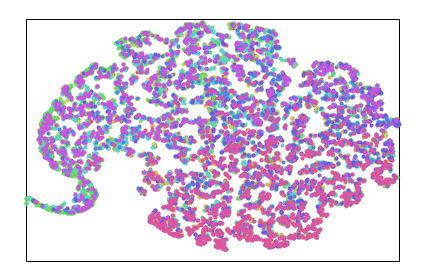

In [71]:
sbvae.visualize_embeddings(-1)